In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import numpy as np
from sklearn.metrics import accuracy_score
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [2]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 0.99
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)
    
def create_checkpoint_callback(model_name):
  return tf.keras.callbacks.ModelCheckpoint(filepath=f"{model_name}/checkpoint.ckpt",
                                                          #  monitor="val_accuracy",
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           save_freq="epoch")

es_cb = EarlyStopping(monitor='val_loss', patience=10)

In [3]:
base_dir = "Multi-class Weather Dataset"
data_dir = pathlib.Path(base_dir)
class_names = sorted([item.name for item in data_dir.glob("*")])
print(class_names)

['Cloudy', 'Rain', 'Shine', 'Sunrise']


In [5]:
datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

# Flow training images in batches of 20 using train_datagen generator
train_generator = datagen.flow_from_directory(
        base_dir,  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        subset='training')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = datagen.flow_from_directory(
        base_dir,
        target_size=(300, 300),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


In [8]:
# Build a model
inputs = layers.Input(shape=(300, 300,3), name="input_layer")
x = layers.Conv2D(filters=10,
                  kernel_size=3,
                  activation="relu")(inputs)
x = layers.Conv2D(filters=10,
                  kernel_size=3,
                  activation="relu")(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(filters=10,
                  kernel_size=3,
                  activation="relu")(x)
x = layers.Conv2D(filters=10,
                  kernel_size=3,
                  activation="relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = tf.keras.Model(inputs, outputs, name="model")

# Compile the model
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
# Fit the model
model_history = model.fit(train_generator,validation_data=(validation_generator),epochs=10,
                              callbacks=[create_checkpoint_callback(model.name)])

Epoch 1/10
46/46 [==============================] - 50s 1s/step - loss: 0.7125 - accuracy: 0.6837 - val_loss: 0.5119 - val_accuracy: 0.8170
Epoch 2/10
46/46 [==============================] - 52s 1s/step - loss: 0.3779 - accuracy: 0.8713 - val_loss: 0.5683 - val_accuracy: 0.7768
Epoch 3/10
46/46 [==============================] - 55s 1s/step - loss: 0.2954 - accuracy: 0.8968 - val_loss: 0.5748 - val_accuracy: 0.7768
Epoch 4/10
46/46 [==============================] - 55s 1s/step - loss: 0.3038 - accuracy: 0.9023 - val_loss: 0.5669 - val_accuracy: 0.8080
Epoch 5/10
46/46 [==============================] - 51s 1s/step - loss: 0.2166 - accuracy: 0.9245 - val_loss: 0.5604 - val_accuracy: 0.7991
Epoch 6/10
46/46 [==============================] - 58s 1s/step - loss: 0.2213 - accuracy: 0.9245 - val_loss: 0.3722 - val_accuracy: 0.8527
Epoch 7/10
46/46 [==============================] - 51s 1s/step - loss: 0.3355 - accuracy: 0.8757 - val_loss: 0.5803 - val_accuracy: 0.7723
Epoch 8/10
46/46 [==

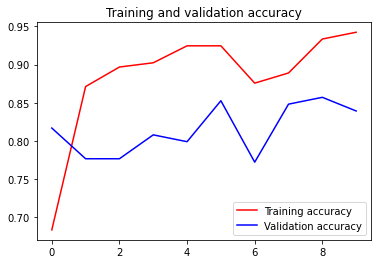

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [12]:
datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

# Flow training images in batches of 20 using train_datagen generator
train_generator = datagen.flow_from_directory(
        base_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        subset='training')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = datagen.flow_from_directory(
        base_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


In [21]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, # Remove dense layer before CONV layers
                                weights = None)
pre_trained_model.trainable=False
pre_trained_model.load_weights('inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x) # Provide fraction of neurons to drop.                 
# Add a final sigmoid layer for classification
x = layers.Dense(len(class_names), activation='softmax')(x)           
model = tf.keras.Model( pre_trained_model.input, x) 
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])
model_history = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=10,
                              callbacks=[create_checkpoint_callback(model.name),es_cb])

Epoch 1/10
46/46 [==============================] - 54s 1s/step - loss: 2.7779 - accuracy: 0.8024 - val_loss: 0.5815 - val_accuracy: 0.9196
Epoch 2/10
46/46 [==============================] - 51s 1s/step - loss: 0.5139 - accuracy: 0.9312 - val_loss: 2.0331 - val_accuracy: 0.8393
Epoch 3/10
46/46 [==============================] - 49s 1s/step - loss: 0.2745 - accuracy: 0.9578 - val_loss: 1.2903 - val_accuracy: 0.8616
Epoch 4/10
46/46 [==============================] - 49s 1s/step - loss: 0.1064 - accuracy: 0.9734 - val_loss: 0.7012 - val_accuracy: 0.8973
Epoch 5/10
46/46 [==============================] - 51s 1s/step - loss: 0.0373 - accuracy: 0.9889 - val_loss: 0.4215 - val_accuracy: 0.9330
Epoch 6/10
46/46 [==============================] - 52s 1s/step - loss: 0.0687 - accuracy: 0.9834 - val_loss: 0.3634 - val_accuracy: 0.9464
Epoch 7/10
46/46 [==============================] - 50s 1s/step - loss: 0.0883 - accuracy: 0.9834 - val_loss: 0.5813 - val_accuracy: 0.9062
Epoch 8/10
46/46 [==